# scratch work

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import astropy.units as u
import jax.numpy as jnp
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.utils.data import download_file
from numpy.polynomial import chebyshev

from jorbit import Particle
from jorbit.data.constants import JORBIT_EPHEM_URL_BASE

In [2]:
ind = 1000
t0 = Time("2020-01-01")
reverse_times = t0 - jnp.arange(0, 20.001, 10 * u.hour.to(u.year)) * u.year
forward_times = t0 + jnp.arange(0, 20.001, 10 * u.hour.to(u.year)) * u.year
names = jnp.load(download_file(JORBIT_EPHEM_URL_BASE + "names.npy", cache=True))
x0_full = jnp.load(download_file(JORBIT_EPHEM_URL_BASE + "x0.npy", cache=True))
v0_full = jnp.load(download_file(JORBIT_EPHEM_URL_BASE + "v0.npy", cache=True))
reverse_pos = jnp.load(download_file(JORBIT_EPHEM_URL_BASE + "reverse_pos.npy", cache=True))
forward_pos = jnp.load(download_file(JORBIT_EPHEM_URL_BASE + "forward_pos.npy", cache=True))

In [3]:
target_index = 1000
chunk_size=30
degree=10

print(f"beginning for {target_index}")

particle = Particle(x=x0_full[target_index], v=v0_full[target_index], time=t0, gravity="newtonian solar system")

t = reverse_times.tdb.jd

print("generating ephemeris")
eph = particle.ephemeris(t, observer=reverse_pos)
eph = eph[::-1]
t = t[::-1]

beginning for 1000
generating ephemeris


In [4]:
print("forming coefficients")
r = jnp.unwrap(eph.ra.rad)
d = eph.dec.rad

num_chunks = int(jnp.ceil((t[-1] - t[0]) / chunk_size))

init = (t[0] - 2451545.0) * 86400.0
intlen = chunk_size * 86400.0

coeffs = jnp.zeros((degree + 1, 2, num_chunks))
for i in range(num_chunks):
    inds = (t >= t[0] + i * chunk_size) & (t < t[0] + (i + 1) * chunk_size)
    t_chunk = t[inds]
    r_chunk = r[inds]
    d_chunk = d[inds]

    # Scale time to [-1, 1] domain
    t_min, t_max = t[0] + i * chunk_size, t[0] + (i + 1) * chunk_size
    t_scaled = 2 * (t_chunk - t_min) / (t_max - t_min) - 1

    # Fit Chebyshev polynomials
    coefficients = chebyshev.chebfit(t_scaled, r_chunk, degree)
    coefficients = coefficients[::-1]
    coeffs = coeffs.at[:, 0, i].set(coefficients)

    coefficients = chebyshev.chebfit(t_scaled, d_chunk, degree)
    coefficients = coefficients[::-1]
    coeffs = coeffs.at[:, 1, i].set(coefficients)

print("done")
result = (init, intlen, coeffs), x0_full[target_index], v0_full[target_index]

forming coefficients
done


In [5]:
from astroquery.jplhorizons import Horizons

from jorbit.mpchecker.parse_jorbit_ephem import (
    get_chunk_index,
    individual_state,
    setup_checks,
)

coordinate, radius, t0, tf, chunk_size, names = setup_checks(
        coordinate=SkyCoord(ra=0 * u.deg, dec=0 * u.deg),
        time=Time("2015-01-01"),
        radius=2*u.arcmin,
    )

index, offset = get_chunk_index(Time("2015-01-01").tdb.jd, t0, tf, chunk_size)

ra, dec = individual_state(
    coefficients=coeffs[:,:,index],
    offset=offset,
    t0=t0,
    chunk_size=chunk_size
)

c = SkyCoord(ra=ra, dec=dec, unit=u.rad)

obj = Horizons(id=names[target_index], location="500@399", epochs=Time("2015-01-01").utc.jd, id_type="smallbody")
eph = obj.ephemerides(extra_precision=True)
eph = SkyCoord(ra=eph["RA"], dec=eph["DEC"], unit=(u.deg, u.deg))

eph.separation(c)

<Angle [5.6857263e-06] deg>

In [ ]:
# import jax

# jax.config.update("jax_enable_x64", True)
# import jax.numpy as jnp
# import os
# import sqlite3
# import sys

# import astropy.units as u
# import numpy as np
# from astropy.time import Time
# from astropy.utils.data import download_file
# from astroquery.jplhorizons import Horizons
# from numpy.polynomial import chebyshev
# from tqdm import tqdm

# from jorbit import Particle
# from jorbit.data.constants import JORBIT_EPHEM_URL_BASE, PERTURBER_PACKED_DESIGNATIONS


# def generate_ephem(x0_index, chunk_size, degree):
#     print(f"beginning for {target_index}")

#     particle = Particle(
#         x=x0_full[target_index],
#         v=v0_full[target_index],
#         time=t0,
#         gravity="newtonian solar system",
#     )

#     t = reverse_times.tdb.jd

#     print("generating ephemeris")
#     eph = particle.ephemeris(t, observer=reverse_pos)
#     eph = eph[::-1]
#     t = t[::-1]

#     print("forming coefficients")
#     r = jnp.unwrap(eph.ra.rad)
#     d = eph.dec.rad

#     num_chunks = int(jnp.ceil((t[-1] - t[0]) / chunk_size))

#     init = (t[0] - 2451545.0) * 86400.0
#     intlen = chunk_size * 86400.0

#     coeffs = jnp.zeros((degree + 1, 2, num_chunks))
#     for i in range(num_chunks):
#         inds = (t >= t[0] + i * chunk_size) & (t < t[0] + (i + 1) * chunk_size)
#         t_chunk = t[inds]
#         r_chunk = r[inds]
#         d_chunk = d[inds]

#         # Scale time to [-1, 1] domain
#         t_min, t_max = t[0] + i * chunk_size, t[0] + (i + 1) * chunk_size
#         t_scaled = 2 * (t_chunk - t_min) / (t_max - t_min) - 1

#         # Fit Chebyshev polynomials
#         coefficients = chebyshev.chebfit(t_scaled, r_chunk, degree)
#         coefficients = coefficients[::-1]
#         coeffs = coeffs.at[:, 0, i].set(coefficients)

#         coefficients = chebyshev.chebfit(t_scaled, d_chunk, degree)
#         coefficients = coefficients[::-1]
#         coeffs = coeffs.at[:, 1, i].set(coefficients)

#     print("done")
#     return (init, intlen, coeffs), x0_full[target_index], v0_full[target_index]


# def adapt_array(arr):
#     """Convert numpy array to binary for SQLite storage"""
#     return arr.tobytes()


# def convert_array(blob):
#     """Convert binary blob back to numpy array"""
#     return np.frombuffer(blob)


# def write_result(target_name, chebyshev_coefficients, x0, v0):

#     with sqlite3.connect(TEMP_DB, timeout=30.0) as conn:
#         # Create the table if it doesn't exist
#         conn.execute(
#             """
#             CREATE TABLE IF NOT EXISTS results
#             (target_name TEXT PRIMARY KEY,
#              chebyshev_coefficients BLOB,
#              x0 BLOB,
#              v0 BLOB)
#         """
#         )

#         # Convert arrays to binary
#         cheby_binary = adapt_array(chebyshev_coefficients)
#         x0_binary = adapt_array(x0)
#         v0_binary = adapt_array(v0)

#         # Insert into temporary database
#         conn.execute(
#             "INSERT OR REPLACE INTO results VALUES (?, ?, ?, ?)",
#             (target_name, cheby_binary, x0_binary, v0_binary),
#         )


# def setup_db():
#     with sqlite3.connect(TEMP_DB, timeout=30.0) as conn:
#         # Create the table if it doesn't exist
#         conn.execute(
#             """
#             CREATE TABLE IF NOT EXISTS results
#             (target_name TEXT PRIMARY KEY,
#              chebyshev_coefficients BLOB,
#              x0 BLOB,
#              v0 BLOB)
#         """
#         )


# def contribute_to_ephem(target_indecies):

#     print(f"Processing {len(target_indecies)} targets")

#     for i, target_index in tqdm(enumerate(target_indecies)):
#         try:
#             target = str(names[target_index])

#             if target in PERTURBER_PACKED_DESIGNATIONS:
#                 print(f"{target} is a perturber, skipping")
#                 continue

#             (_, _, coeffs), x0, v0 = generate_ephem(
#                 particle_name=target_index, chunk_size=30, degree=10
#             )
#             print("writing result to database\n")
#             write_result(target, coeffs, x0, v0)
#         except Exception as e:
#             print(f"Error processing target {target_index}: {e}")
#             continue

#     return targets


# target_indecies = sys.argv[1:]

# print("loading data")
# t0 = Time("2020-01-01")
# reverse_times = t0 - jnp.arange(0, 20.001, 10 * u.hour.to(u.year)) * u.year
# names = jnp.load(download_file(JORBIT_EPHEM_URL_BASE + "names.npy"))
# x0_full = jnp.load(download_file(JORBIT_EPHEM_URL_BASE + "x0.npy"))
# v0_full = jnp.load(download_file(JORBIT_EPHEM_URL_BASE + "v0.npy"))
# reverse_pos = jnp.load(
#     download_file(JORBIT_EPHEM_URL_BASE + "reverse_pos.npy", cache=True)
# )

# print("setting up database")
# arr_id = os.environ.get("SLURM_ARRAY_TASK_ID", "ARRAY_ID_NOT_FOUND")
# job_id = os.environ.get("SLURM_JOB_ID", "JOB_ID_NOT_FOUND")
# if arr_id == "ARRAY_ID_NOT_FOUND" or job_id == "JOB_ID_NOT_FOUND":
#     raise ValueError("SLURM environment variables not found")

# TEMP_DB = f"db_results/temp_results_rev_{arr_id}_{job_id}.db"

# setup_db()

# print("beginning integrations")
# contribute_to_ephem(target_indecies=target_indecies)

In [ ]:
# tic: 471016459 sector: 42
#   Unpacked Name    Packed designation   H    G   ... Computer Flags last obs
# ------------------ ------------------ ----- ---- ... -------- ----- --------
#         (2) Pallas              00002  4.11 0.15 ...      Pan  4000 20240927
# (19712) 1999 TL220              19712 12.99 0.15 ... MPCLINUX  0000 20250212
#  (64522) 2001 VJ98              64522 14.24 0.15 ... MPCLINUX  0000 20240711



# tic: 392088911 sector: 45
# Unpacked Name Packed designation   H    G   ... Computer Flags last obs
# ------------- ------------------ ----- ---- ... -------- ----- --------
#      (7) Iris              00007  5.67 0.15 ... MPCLINUX  0000 20250105
# (13677) Alvin              13677 13.84 0.15 ... MPCLINUX  0000 20240805
#    (3375) Amy              03375 14.11 0.15 ... MPCLINUX  0000 20250219



# tic: 245830829 sector: 70
#    Unpacked Name    Packed designation   H    G   ... Computer Flags last obs
# ------------------- ------------------ ----- ---- ... -------- ----- --------
#         (65) Cybele              00065  6.84 0.15 ... MPCLINUX  0000 20250219
# (140810) 2001 UM158              E0810 15.53 0.15 ... MPCLINUX  0000 20250206
# (345970) 2007 TU103              Y5970  16.4 0.15 ... MPCLINUX  0000 20250118



# tic: 245792139 sector: 71
#    Unpacked Name    Packed designation   H    G   ... Computer Flags last obs
# ------------------- ------------------ ----- ---- ... -------- ----- --------
#         (65) Cybele              00065  6.84 0.15 ... MPCLINUX  0000 20250219
#   (56759) 2000 OU18              56759 15.19 0.15 ... MPCLINUX  0000 20250216
# (353314) 2010 JH161              Z3314  16.0 0.15 ... MPCLINUX  0000 20250121



# tic: 34947258 sector: 72
#   Unpacked Name   Packed designation   H    G   ... Computer Flags last obs
# ----------------- ------------------ ----- ---- ... -------- ----- --------
#          (3) Juno              00003  5.18 0.15 ...      Pan  4000 20240607
#      (1832) Mrkos              01832 11.25 0.15 ... MPCLINUX  0000 20250218
# (87658) 2000 RE93              87658 14.24 0.15 ... MPCLINUX  0000 20240502



# tic: 374272870 sector: 72
#   Unpacked Name   Packed designation   H    G   ... Computer Flags last obs
# ----------------- ------------------ ----- ---- ... -------- ----- --------
#          (3) Juno              00003  5.18 0.15 ...      Pan  4000 20240607
#         2006 AM98            K06A98M   7.4 0.15 ...    Veres  000A 20190302
# (30486) 2000 PE23              30486 13.95 0.15 ... MPCLINUX  0000 20240705



# tic: 400465017 sector: 72
#   Unpacked Name    Packed designation   H    G   ... Computer Flags last obs
# ------------------ ------------------ ----- ---- ... -------- ----- --------
#   (704) Interamnia              00704  6.34 0.15 ... MPCLINUX  0000 20250129
#  (54181) 2000 HR65              54181 14.77 0.15 ... MPCLINUX  0000 20250209
# (146565) 2001 TU21              E6565 15.69 0.15 ... MPCLINUX  0000 20250206

In [6]:

%matplotlib inline
import lightkurve as lk

search = lk.search_targetpixelfile("TIC 400465017", sector=72)
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 72,2023,SPOC,20,400465017,0.0
1,TESS Sector 72,2023,SPOC,120,400465017,0.0
2,TESS Sector 72,2023,TESS-SPOC,200,400465017,0.0


In [ ]:
# tpf = search[0].download()
# step = len(tpf[8500:13000]) // 60

# tpf[8500:13000].animate(step=step, interval=60, **{"vmin":0, "vmax":5000})

<Axes: title={'center': 'Target ID: 400465017, Cadence: 8786391'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

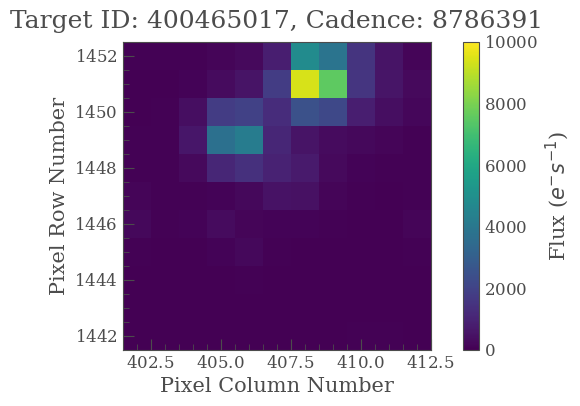

In [ ]:
# tpf[5000].plot(**{"vmin":0, "vmax":10000})

In [ ]:
# from astroquery.jplhorizons import Horizons

# obj = Horizons(
#     id="2",
#     location="@-95",
#     id_type="smallbody",
#     epochs={"start": "2010-01-01", "stop": "2010-03-01", "step": "10d"},
# )